# Задача прогнозирования минимального баланса клиентов банка

**Цель проекта**<br>
Предсказать, какие клиенты банка сохранят положительный баланс на своих счетах. Банк заинтересован в том, чтобы клиенты поддерживали ненулевой остаток на картах, так как обнуление баланса является нежелательным исходом.

**Ключевые характеристики**
- Классификация клиентов происходит на основе их минимального баланса в последующем месяце
- Существует прямая зависимость между номером группы и размером минимального баланса
- Основной фокус направлен на выявление клиентов с высоким риском снижения остатка до минимальных значений

**Метрика**<br>
[WMAE](https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html) - Взвешенная средняя абсолютная ошибка

## Анализ данных

In [1]:
# Импорт библиотек и модулей
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import (mean_absolute_error, mean_squared_error)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import (CatBoostRegressor, CatBoostClassifier)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%%time
# Загружаем датасет
df = pd.read_csv('df_transaction_csv.csv')

CPU times: total: 34.2 s
Wall time: 57.7 s


In [4]:
# Смотрим результат
df.head()

,client_num,date_time,mcc_code,merchant_name,amount
0,0,2024-07-18 16:04:00,8099,a011100358d0f73ea8f3e860ef5564e3ba9cb217b7b90c...,2900
1,0,2024-07-22 16:31:00,5411,f3855606fc7244ec2f37ea01a4b2b66933d0e965bf4aec...,455
2,0,2024-07-24 16:23:00,5541,786270fa33ad4ac2a3c0e52e888005aa7f98beadbf8986...,1003
3,0,2024-07-28 15:51:00,5691,54887ad4a8df7e260a3ac85e59128a947c50d4423f6330...,1480
4,0,2024-07-28 18:00:00,5331,21617559a372c7cca155208c87be6c84ce97b5f8775589...,88


**Описания столбцов**
- client_num - номер клиента
- date_time - время транзакции
- mcc_code - МСС код
- merchant_name - hash имени мерчанта
- amount - сумма транзакции

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13508155 entries, 0 to 13508154
Data columns (total 5 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   client_num     int64 
 1   date_time      object
 2   mcc_code       int64 
 3   merchant_name  object
 4   amount         int64 
dtypes: int64(3), object(2)
memory usage: 515.3+ MB


In [6]:
%%time
# Проверка на явные дубликаты
df.duplicated().sum()

CPU times: total: 17.2 s
Wall time: 19.5 s


91358

In [7]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)

In [8]:
# Загружаем train
train = pd.read_csv('train_csv.csv')

In [9]:
# Смотрим результат
train.head()

,client_num,target
0,94779,3
1,17279,0
2,5717,2
3,27471,1
4,72725,0


In [10]:
# Посмотрим на уникальные значения целевой переменной
train['target'].unique()

array([3, 0, 2, 1, 5, 4, 6], dtype=int64)

In [11]:
# Посмотрим на доли значений
train['target'].value_counts(normalize=True)

target
1    0.257429
0    0.215586
2    0.141043
4    0.114771
3    0.114100
5    0.078671
6    0.078400
Name: proportion, dtype: float64

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   client_num  70000 non-null  int64
 1   target      70000 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


## Работа с данными

### Оставляем в датасете только нужные для расчётов столбцы

In [13]:
data = df[['client_num', 'date_time', 'mcc_code', 'amount']].copy()

In [14]:
data.head()

,client_num,date_time,mcc_code,amount
0,0,2024-07-18 16:04:00,8099,2900
1,0,2024-07-22 16:31:00,5411,455
2,0,2024-07-24 16:23:00,5541,1003
3,0,2024-07-28 15:51:00,5691,1480
4,0,2024-07-28 18:00:00,5331,88


In [15]:
# Переводим тип столбца 'date_time' во временнОй
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13416797 entries, 0 to 13508154
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   client_num  int64         
 1   date_time   datetime64[ns]
 2   mcc_code    int64         
 3   amount      int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 511.8 MB


In [17]:
#Добавляем столбец month с месяцем транзакции
data['month'] = data['date_time'].dt.month

In [18]:
data.head(10)

,client_num,date_time,mcc_code,amount,month
0,0,2024-07-18 16:04:00,8099,2900,7
1,0,2024-07-22 16:31:00,5411,455,7
2,0,2024-07-24 16:23:00,5541,1003,7
3,0,2024-07-28 15:51:00,5691,1480,7
4,0,2024-07-28 18:00:00,5331,88,7
5,0,2024-07-29 11:24:00,5921,65,7
6,0,2024-07-29 17:32:00,5411,70,7
7,0,2024-07-29 18:11:00,5499,39,7
8,0,2024-07-30 14:25:00,5921,583,7
9,0,2024-07-31 19:43:00,5541,578,7


In [19]:
# Выведем уникальные значения столбца с месяцем
data['month'].unique()

array([ 7,  8,  9, 10])

In [20]:
# Удалим столбец 'date_time' за ненадобностью
data.drop('date_time', axis=1, inplace=True)

In [21]:
data.head()

,client_num,mcc_code,amount,month
0,0,8099,2900,7
1,0,5411,455,7
2,0,5541,1003,7
3,0,5691,1480,7
4,0,5331,88,7


Создадим сводную таблицу, где для каждого client_num укажем:
- сумму транзакций 'sum' за каждый месяц
- среднюю странзакцию 'mean' за каждый месяц
- кол - во транзакций за каждый месяц
- кол- во уникальных mcc-кодов за каждый месяц

In [22]:
data_pivot = data.pivot_table(index='client_num', 
                                columns='month', 
                                values=['amount', 'mcc_code'], 
                                aggfunc={'amount':['sum', 'mean', 'count'], 'mcc_code':'nunique'}).reset_index()

In [23]:
data_pivot.head()

client_num amount                                             \
                  count                          mean                
month                 7     8     9  10             7            8   
0              0   10.0  66.0  56.0 NaN    726.100000   863.060606   
1              1   95.0  68.0  77.0 NaN   4449.989474  3480.485294   
2              2  128.0  77.0  95.0 NaN    895.679688  1046.103896   
3              3   42.0  58.0  47.0 NaN  35331.261905  1174.189655   
4              4   60.0  22.0  40.0 NaN   1523.700000  2895.909091   

                                                          mcc_code        \
                              sum                          nunique         
month            9  10          7         8         9  10        7     8   
0       762.714286 NaN     7261.0   56962.0   42712.0 NaN      7.0  12.0   
1      2655.272727 NaN   422749.0  236673.0  204456.0 NaN     22.0  20.0   
2      1567.484211 NaN   114647.0   80550.0  148911.0 NaN     22.0  12.0   
3      1485.297872 NaN  1483913.0   68103.0   69809.0 NaN     11.0  14.0   
4      1116.600000 NaN    91422.0   63710.0   44664.0 NaN      8.0   5.0   

                 
                 
month     9  10  
0      14.0 NaN  
1      16.0 NaN  
2      25.0 NaN  
3      12.0 NaN  
4       6.0 NaN

In [24]:
# Переименуем столбцы
data_pivot.columns = ['client_num',
                        'count_7', 'count_8', 'count_9', 'count_10',
                        'mean_7', 'mean_8', 'mean_9', 'mean_10',
                        'sum_7', 'sum_8', 'sum_9', 'sum_10', 
                        'mcc_7', 'mcc_8', 'mcc_9', 'mcc_10']

In [25]:
data_pivot.head()

,client_num,count_7,count_8,count_9,count_10,mean_7,mean_8,mean_9,mean_10,sum_7,sum_8,sum_9,sum_10,mcc_7,mcc_8,mcc_9,mcc_10
0,0,10.0,66.0,56.0,NaN,726.100000,863.060606,762.714286,NaN,7261.0,56962.0,42712.0,NaN,7.0,12.0,14.0,NaN
1,1,95.0,68.0,77.0,NaN,4449.989474,3480.485294,2655.272727,NaN,422749.0,236673.0,204456.0,NaN,22.0,20.0,16.0,NaN
2,2,128.0,77.0,95.0,NaN,895.679688,1046.103896,1567.484211,NaN,114647.0,80550.0,148911.0,NaN,22.0,12.0,25.0,NaN
3,3,42.0,58.0,47.0,NaN,35331.261905,1174.189655,1485.297872,NaN,1483913.0,68103.0,69809.0,NaN,11.0,14.0,12.0,NaN
4,4,60.0,22.0,40.0,NaN,1523.700000,2895.909091,1116.600000,NaN,91422.0,63710.0,44664.0,NaN,8.0,5.0,6.0,NaN


In [26]:
# Выведем кол-во пустых значений
data_pivot.isna().sum()

client_num         0
count_7        13876
count_8         7849
count_9         7118
count_10      109139
mean_7         13876
mean_8          7849
mean_9          7118
mean_10       109139
sum_7          13876
sum_8           7849
sum_9           7118
sum_10        109139
mcc_7          13876
mcc_8           7849
mcc_9           7118
mcc_10        109139
dtype: int64

In [27]:
# Посмотрим кол-во клиентов с транзакциями за 10 месяц
data_pivot.loc[~data_pivot['sum_10'].isna()]

,client_num,count_7,count_8,count_9,count_10,mean_7,mean_8,mean_9,mean_10,sum_7,sum_8,sum_9,sum_10,mcc_7,mcc_8,mcc_9,mcc_10
13168,13168,65.0,107.0,50.0,1.0,14231.446154,7930.429907,11563.740000,3280.0,925044.0,848556.0,578187.0,3280.0,22.0,27.0,18.0,1.0
26937,26937,84.0,89.0,94.0,1.0,399.107143,736.089888,466.074468,132.0,33525.0,65512.0,43811.0,132.0,12.0,19.0,15.0,1.0
78137,78137,102.0,64.0,63.0,1.0,1610.911765,1461.968750,569.365079,64.0,164313.0,93566.0,35870.0,64.0,18.0,8.0,13.0,1.0
93720,93720,2.0,37.0,50.0,1.0,144.000000,170.162162,114.720000,31.0,288.0,6296.0,5736.0,31.0,1.0,3.0,6.0,1.0


Для 10-го месяца мало данных, поэтому удалим столбцы с этим месяцем

In [28]:
# Удаляем столбцы за 10 месяц, т.к. мало данных
data_pivot.drop(['count_10', 'mean_10', 'sum_10', 'mcc_10'], axis=1, inplace=True)

In [29]:
# Вычислим сред. кол-во и сумму транзакций ,среднюю транзакццию и среднее кол-вл мсс-кодов за месяц для каждого клиента
data_pivot['count_mean'] = data_pivot[['count_7', 'count_8', 'count_9']].mean(axis=1)
data_pivot['sum_mean'] = data_pivot[['sum_7', 'sum_8', 'sum_9']].mean(axis=1)
data_pivot['mean_mean'] = data_pivot[['mean_7', 'mean_8', 'mean_9']].mean(axis=1)
data_pivot['mcc_mean'] = data_pivot[['mcc_7', 'mcc_8', 'mcc_9']].mean(axis=1)

In [30]:
# Присоединяем train
data_pivot = data_pivot.merge(train, how='outer', on='client_num')

In [31]:
# Смотрим результат
data_pivot.head()

,client_num,count_7,count_8,count_9,mean_7,mean_8,mean_9,sum_7,sum_8,sum_9,mcc_7,mcc_8,mcc_9,count_mean,sum_mean,mean_mean,mcc_mean,target
0,0,10.0,66.0,56.0,726.100000,863.060606,762.714286,7261.0,56962.0,42712.0,7.0,12.0,14.0,44.000000,35645.000000,783.958297,11.000000,NaN
1,1,95.0,68.0,77.0,4449.989474,3480.485294,2655.272727,422749.0,236673.0,204456.0,22.0,20.0,16.0,80.000000,287959.333333,3528.582498,19.333333,4.0
2,2,128.0,77.0,95.0,895.679688,1046.103896,1567.484211,114647.0,80550.0,148911.0,22.0,12.0,25.0,100.000000,114702.666667,1169.755931,19.666667,5.0
3,3,42.0,58.0,47.0,35331.261905,1174.189655,1485.297872,1483913.0,68103.0,69809.0,11.0,14.0,12.0,49.000000,540608.333333,12663.583144,12.333333,3.0
4,4,60.0,22.0,40.0,1523.700000,2895.909091,1116.600000,91422.0,63710.0,44664.0,8.0,5.0,6.0,40.666667,66598.666667,1845.403030,6.333333,5.0


In [32]:
# Выведем кол-во клиентов с пропущенной целевой переменной
data_pivot['target'].isna().sum()

39143

In [33]:
# Проверим пропуски
data_pivot.isna().sum()

client_num        0
count_7       13876
count_8        7849
count_9        7118
mean_7        13876
mean_8         7849
mean_9         7118
sum_7         13876
sum_8          7849
sum_9          7118
mcc_7         13876
mcc_8          7849
mcc_9          7118
count_mean        0
sum_mean          0
mean_mean         0
mcc_mean          0
target        39143
dtype: int64

### Исследуем группы на выбросы

In [34]:
# Функция для построения диаграммы "ящик с усами" и выделения из таблицы группы п оцеелвой переменной
def groups(g):
    group = data_pivot.dropna()
    group = group.loc[group['target'] == g]
    display(group[['count_mean', 'sum_mean', 'mean_mean', 'mcc_mean']].describe())
    plt.figure(figsize =(20, 1))
    sns.boxplot(group['count_mean'], orient='h')
    plt.figure(figsize =(20, 1))
    sns.boxplot(group['sum_mean'], orient='h')
    plt.figure(figsize =(20, 1))
    sns.boxplot(group['mean_mean'], orient='h')
    plt.figure(figsize =(20, 1))
    sns.boxplot(group['mcc_mean'], orient='h')
    return group

**Группа 0**

,count_mean,sum_mean,mean_mean,mcc_mean
count,10140.000000,1.014000e+04,10140.000000,10140.000000
mean,32.502334,7.449133e+04,4361.881704,7.569888
std,30.884368,5.503247e+05,16079.673594,4.446912
min,4.333333,1.783333e+02,21.921917,1.000000
25%,11.333333,1.202458e+04,576.038253,4.333333
50%,22.333333,2.816733e+04,1161.861189,6.666667
75%,43.000000,6.306467e+04,2700.554887,10.000000
max,409.333333,5.288513e+07,416666.666667,49.666667


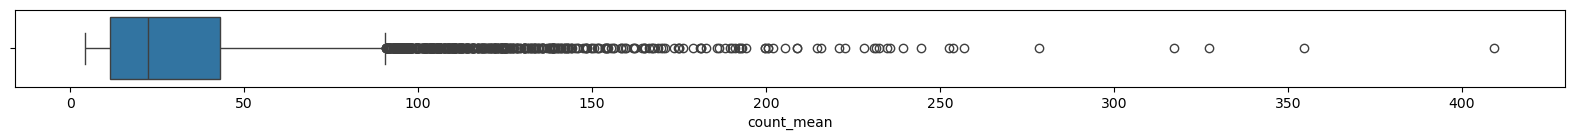

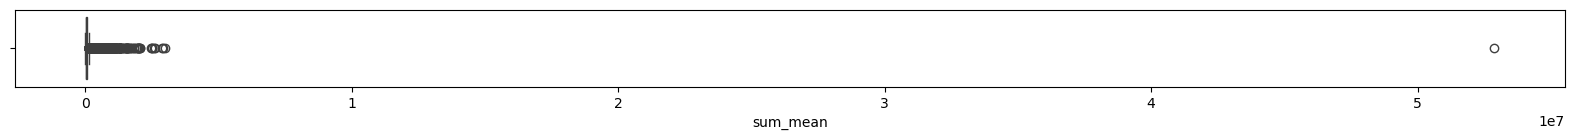

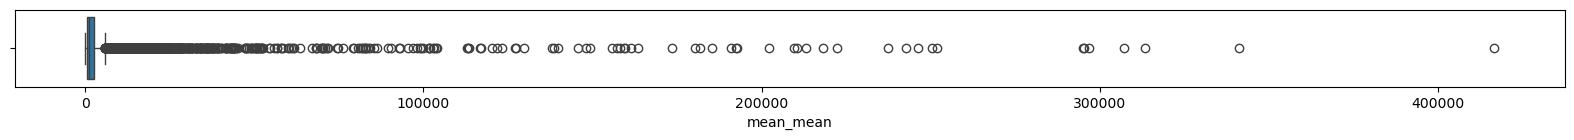

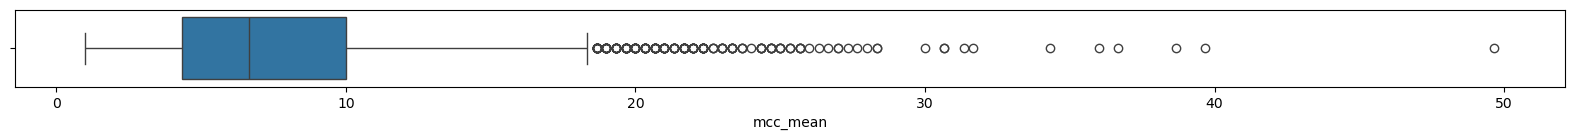

In [35]:
group_0 = groups(0)

In [36]:
# Индексы из группы 0 на удаление
list_0 = list(group_0.query('sum_mean == 5.288513e+07 | mean_mean == 50000.0 | mcc_mean > 30').index)

**Группа 1**

,count_mean,sum_mean,mean_mean,mcc_mean
count,13463.000000,1.346300e+04,13463.000000,13463.000000
mean,37.529377,6.626394e+04,3355.355558,8.201837
std,31.196042,2.063033e+05,15444.814239,4.445953
min,4.000000,1.466667e+01,2.543757,1.000000
25%,14.666667,1.062717e+04,428.561254,4.666667
50%,28.333333,2.440800e+04,784.823016,7.333333
75%,51.000000,5.316317e+04,1676.730322,10.666667
max,403.000000,9.080037e+06,500770.222222,31.333333


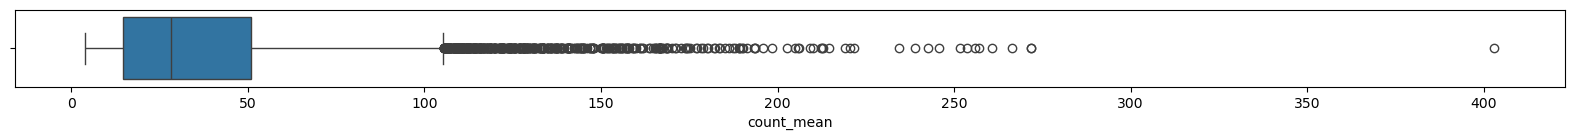

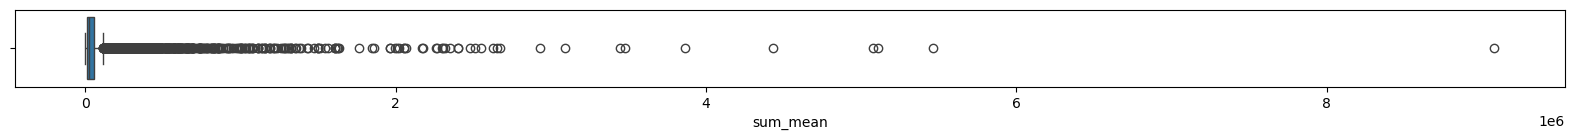

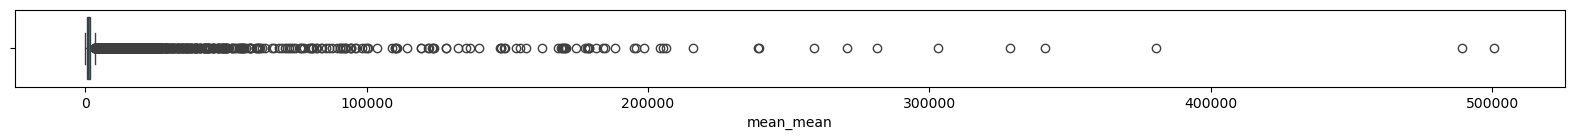

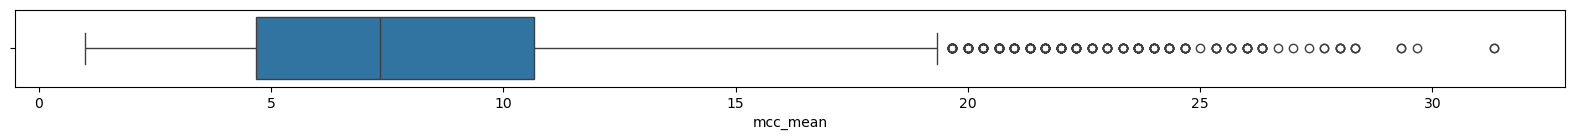

In [37]:
group_1 = groups(1)

In [38]:
# Индексы из группы 1 на удаление
list_1 = list(group_1.query('sum_mean > 6000000 | mean_mean > 300000 | mcc_mean > 20').index)

**Группа 2**

,count_mean,sum_mean,mean_mean,mcc_mean
count,8119.000000,8.119000e+03,8119.000000,8119.000000
mean,44.596174,8.206652e+04,3661.446369,9.429281
std,33.334281,2.648119e+05,16900.467449,4.767124
min,4.000000,1.556667e+02,20.601852,1.000000
25%,19.333333,1.541933e+04,478.003157,5.666667
50%,37.000000,3.219167e+04,830.710355,9.000000
75%,61.333333,6.738983e+04,1696.585498,12.333333
max,402.333333,9.394667e+06,447913.991597,39.666667


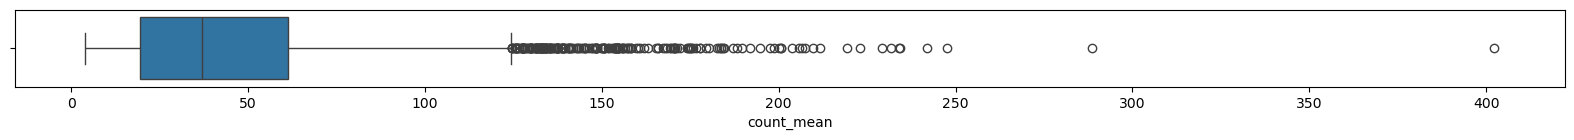

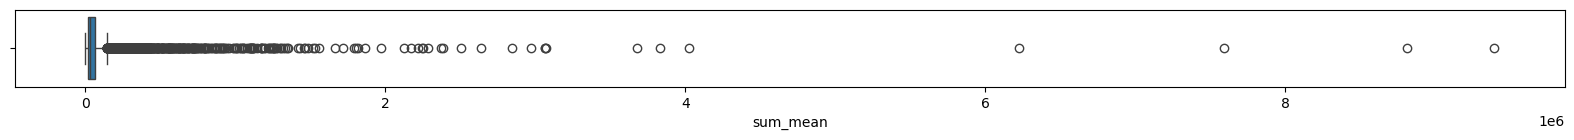

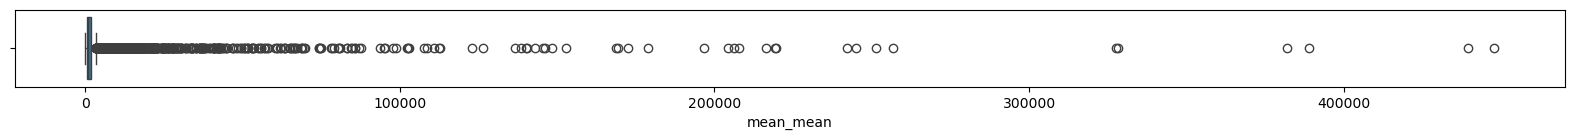

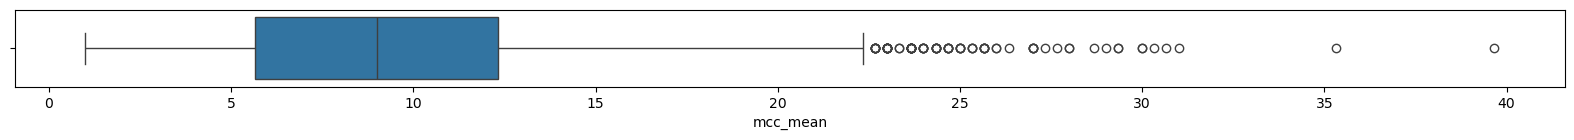

In [39]:
group_2 = groups(2)

In [40]:
# Индексы из группы 2 на удаление
list_2 = list(group_2.query('sum_mean > 3500000 | mean_mean > 300000 | mcc_mean > 22').index)

**Группа 3**

,count_mean,sum_mean,mean_mean,mcc_mean
count,6928.000000,6.928000e+03,6928.000000,6928.000000
mean,55.793303,9.165108e+04,3330.338421,10.870044
std,39.059370,2.358852e+05,14822.712815,5.197284
min,5.000000,4.793333e+02,33.021605,1.000000
25%,26.000000,2.193925e+04,521.753745,7.000000
50%,49.000000,4.222567e+04,871.095264,10.500000
75%,76.000000,8.220808e+04,1650.427204,14.333333
max,330.666667,8.089026e+06,292848.333333,36.333333


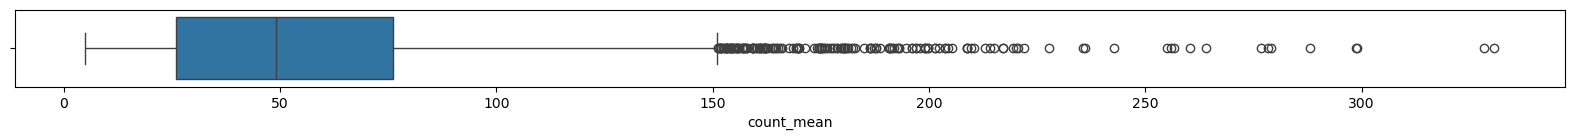

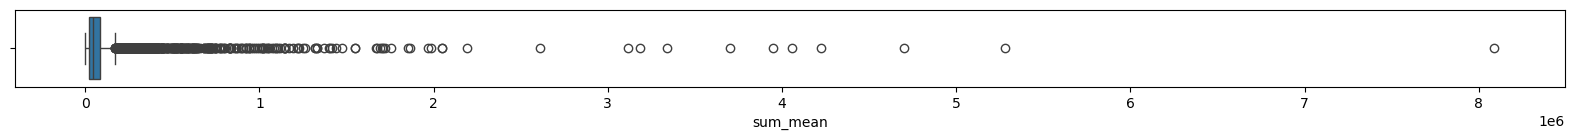

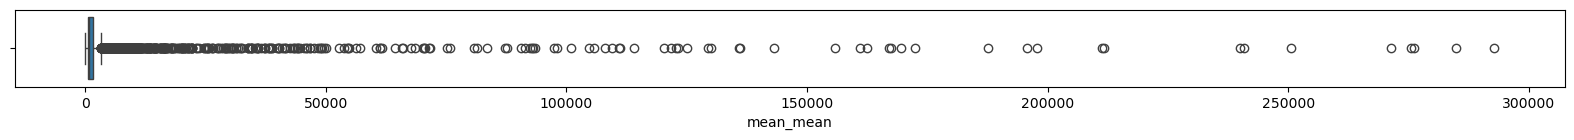

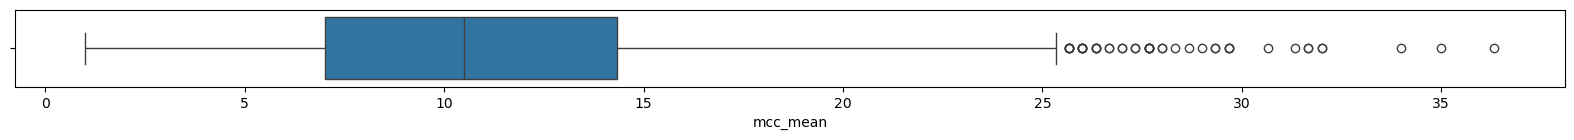

In [41]:
group_3 = groups(3)

In [42]:
# Индексы из группы 3 на удаление
list_3 = list(group_3.query('sum_mean > 6000000 | mean_mean > 300000 | mcc_mean > 25').index)

**Группа 4**

,count_mean,sum_mean,mean_mean,mcc_mean
count,7165.000000,7.165000e+03,7165.000000,7165.000000
mean,65.925238,1.279178e+05,3531.598445,12.332449
std,45.688805,3.487946e+05,16812.121932,5.852917
min,4.666667,2.983333e+02,47.650505,1.000000
25%,31.333333,3.118967e+04,611.956197,8.000000
50%,57.333333,5.789800e+04,1015.930060,12.000000
75%,91.000000,1.163180e+05,1987.986526,16.000000
max,402.000000,1.546325e+07,818006.181818,41.333333


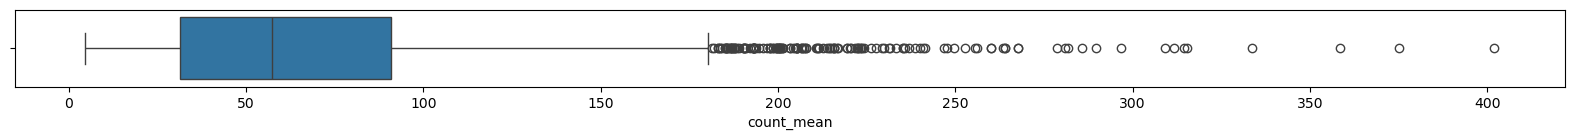

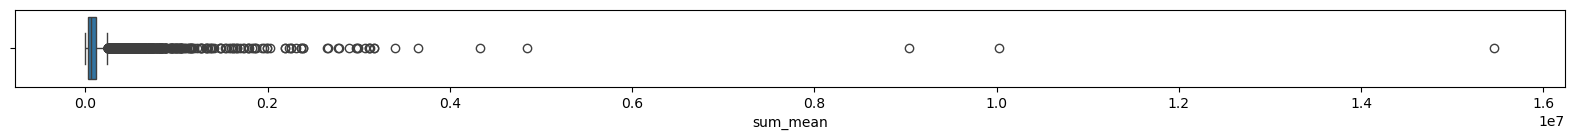

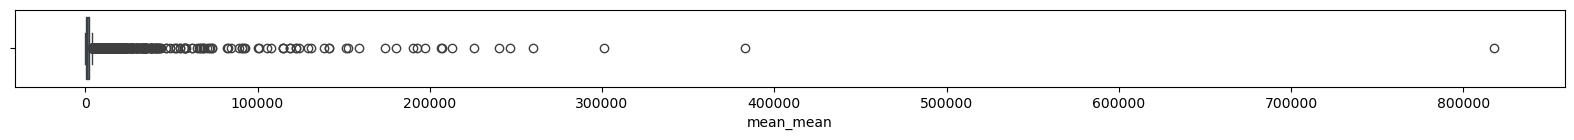

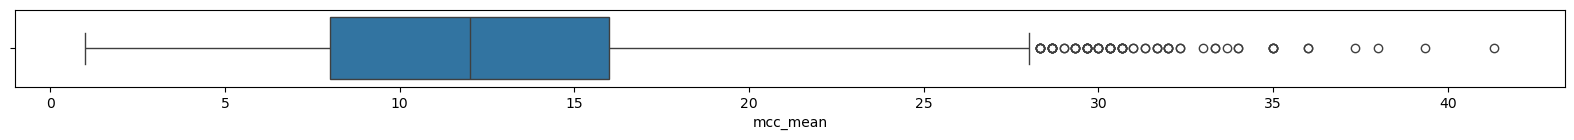

In [43]:
group_4 = groups(4)

In [44]:
# Индексы из группы 4 на удаление
list_4 = list(group_4.query('sum_mean > 6000000 | mean_mean > 300000 | mcc_mean > 28').index)

**Группа 5**

,count_mean,sum_mean,mean_mean,mcc_mean
count,4964.000000,4.964000e+03,4964.000000,4964.000000
mean,61.510610,1.809410e+05,4860.648242,12.250000
std,48.012528,4.465814e+05,18659.090215,6.688929
min,4.333333,7.080000e+02,43.403509,1.000000
25%,25.000000,3.036742e+04,753.166841,7.000000
50%,51.000000,6.638617e+04,1362.854959,11.333333
75%,84.666667,1.557658e+05,2895.951421,16.000000
max,513.666667,1.257321e+07,504166.666667,47.333333


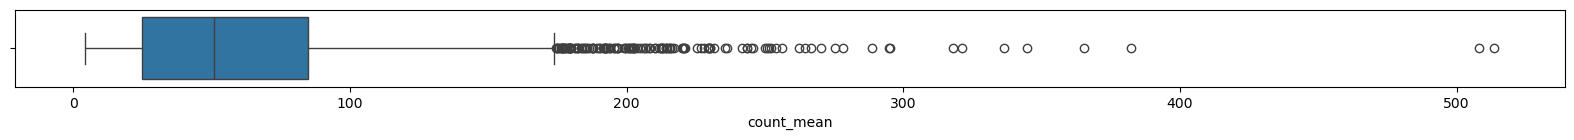

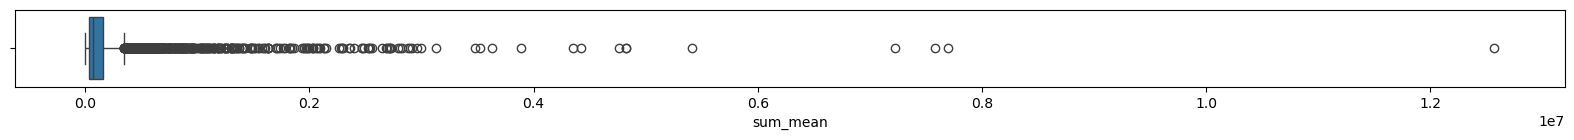

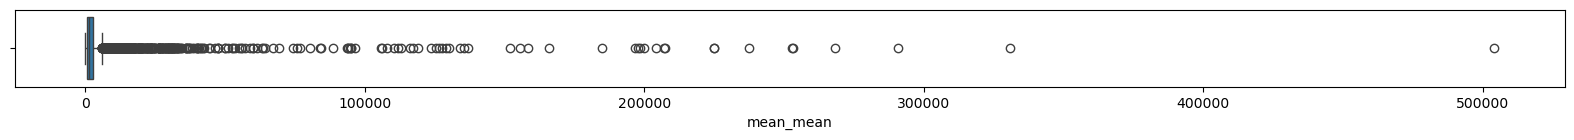

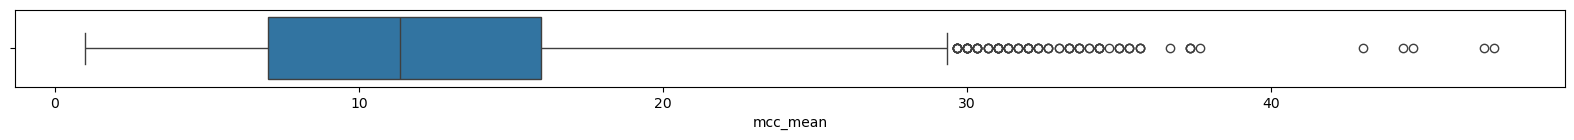

In [45]:
group_5 = groups(5)

In [46]:
# Индексы из группы 5 на удаление
list_5 = list(group_5.query('sum_mean > 6000000 | mean_mean > 250000 | mcc_mean > 30').index)

**Группа 6**

,count_mean,sum_mean,mean_mean,mcc_mean
count,5032.000000,5.032000e+03,5.032000e+03,5032.000000
mean,53.948861,2.852520e+05,1.072146e+04,11.079425
std,52.059772,1.369578e+06,5.098985e+04,6.688488
min,4.666667,4.850000e+02,8.100198e+01,1.000000
25%,20.000000,3.342392e+04,9.112576e+02,6.333333
50%,41.333333,7.389550e+04,1.850512e+03,10.000000
75%,72.000000,1.958511e+05,5.083769e+03,14.666667
max,1121.333333,6.900833e+07,2.270111e+06,50.333333


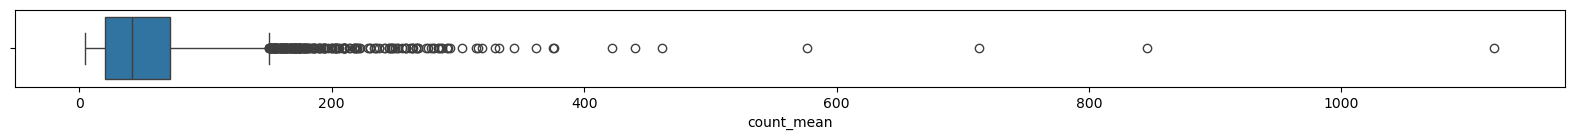

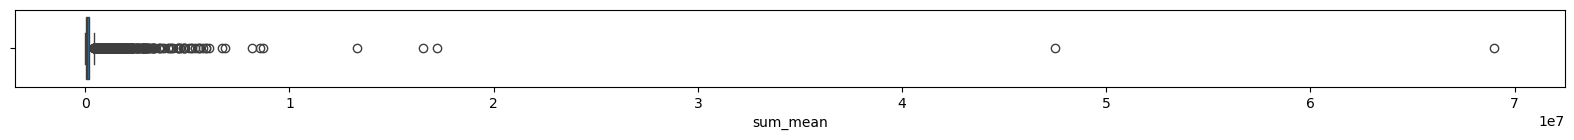

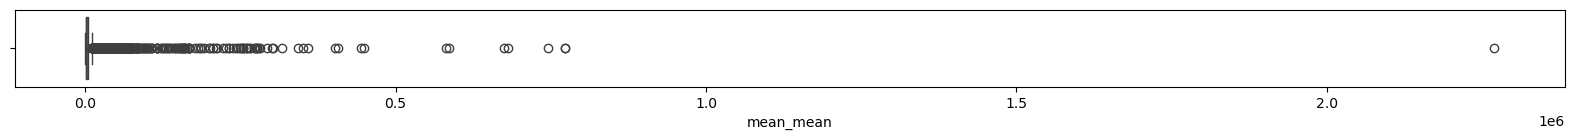

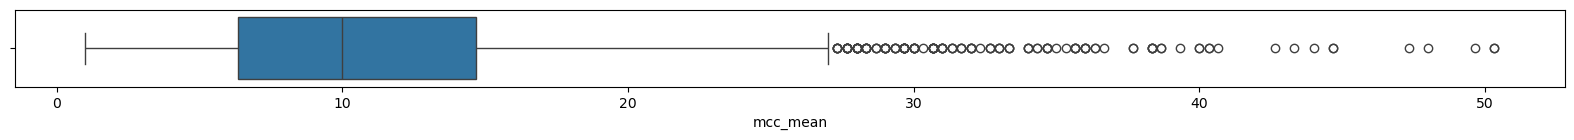

In [47]:
group_6 = groups(6)

In [48]:
# Индексы из группы 6 на удаление
list_6 = list(group_6.query('sum_mean > 10_000_000 | mean_mean > 500_000 | mcc_mean > 28').index)

In [49]:
# Объединим индексы из всех групп
remove_list = list_0 + list_1 + list_2 + list_3 + list_4 + list_5 + list_6

In [50]:
# Удалим индексы из таблицы
data_pivot.drop(remove_list, inplace=True)

In [51]:
# Проверим по групбай после удаления выбросов
data_pivot.groupby('target')[['count_mean', 'mean_mean', 'sum_mean', 'mcc_mean']].mean()

,count_mean,mean_mean,sum_mean,mcc_mean
target,,,,
0.0,31.231539,4389.272350,82496.857757,7.330338
1.0,34.262567,3084.293157,60150.514103,7.660271
2.0,41.760994,3276.568789,71606.537465,8.922530
3.0,52.832283,3618.210254,90030.909106,10.380712
4.0,62.176931,3487.745943,117860.727271,11.761899
5.0,57.057328,4536.448462,158118.154924,11.526958
6.0,49.425398,9552.789852,227705.708271,10.338584


### Заполним пропуски медианой по столбцам

In [52]:
data_pivot.loc[data_pivot['count_7'].isna(), 'count_7'] = data_pivot['count_7'].median()
data_pivot.loc[data_pivot['count_8'].isna(), 'count_8'] = data_pivot['count_8'].median()
data_pivot.loc[data_pivot['count_9'].isna(), 'count_9'] = data_pivot['count_9'].median()

In [53]:
data_pivot.loc[data_pivot['mean_7'].isna(), 'mean_7'] = data_pivot['mean_7'].median()
data_pivot.loc[data_pivot['mean_8'].isna(), 'mean_8'] = data_pivot['mean_8'].median()
data_pivot.loc[data_pivot['mean_9'].isna(), 'mean_9'] = data_pivot['mean_9'].median()

In [54]:
data_pivot.loc[data_pivot['sum_7'].isna(), 'sum_7'] = data_pivot['sum_7'].median()
data_pivot.loc[data_pivot['sum_8'].isna(), 'sum_8'] = data_pivot['sum_8'].median()
data_pivot.loc[data_pivot['sum_9'].isna(), 'sum_9'] = data_pivot['sum_9'].median()

In [55]:
data_pivot.loc[data_pivot['mcc_7'].isna(), 'mcc_7'] = data_pivot['mcc_7'].median()
data_pivot.loc[data_pivot['mcc_8'].isna(), 'mcc_8'] = data_pivot['mcc_8'].median()
data_pivot.loc[data_pivot['mcc_9'].isna(), 'mcc_9'] = data_pivot['mcc_9'].median()

In [56]:
# Проверим пропуски
data_pivot.isna().sum()

client_num        0
count_7           0
count_8           0
count_9           0
mean_7            0
mean_8            0
mean_9            0
sum_7             0
sum_8             0
sum_9             0
mcc_7             0
mcc_8             0
mcc_9             0
count_mean        0
sum_mean          0
mean_mean         0
mcc_mean          0
target        39143
dtype: int64

In [57]:
# Проверим по групбай после заполнения пропусков
data_pivot.groupby('target')[['count_mean', 'mean_mean', 'sum_mean', 'mcc_mean']].mean()

,count_mean,mean_mean,sum_mean,mcc_mean
target,,,,
0.0,31.231539,4389.272350,82496.857757,7.330338
1.0,34.262567,3084.293157,60150.514103,7.660271
2.0,41.760994,3276.568789,71606.537465,8.922530
3.0,52.832283,3618.210254,90030.909106,10.380712
4.0,62.176931,3487.745943,117860.727271,11.761899
5.0,57.057328,4536.448462,158118.154924,11.526958
6.0,49.425398,9552.789852,227705.708271,10.338584


## Моделирование

### Добавление признаков

In [58]:
# Добавим признаки. Считаем, что столбец с приставкой "_mean" это данные за 10-й месяц
data_pivot['count_8/7'] = data_pivot['count_8']/data_pivot['count_7']
data_pivot['count_9/8'] = data_pivot['count_9']/data_pivot['count_8']
data_pivot['count_10/9'] = data_pivot['count_mean']/data_pivot['count_9']

data_pivot['mean_8/7'] = data_pivot['mean_8']/data_pivot['mean_7']
data_pivot['mean_9/8'] = data_pivot['mean_9']/data_pivot['mean_8']
data_pivot['mean_10/9'] = data_pivot['mean_mean']/data_pivot['mean_9']

data_pivot['sum_8/7'] = data_pivot['sum_8']/data_pivot['sum_7']
data_pivot['sum_9/8'] = data_pivot['sum_9']/data_pivot['sum_8']
data_pivot['sum_10/9'] = data_pivot['sum_mean']/data_pivot['sum_9']

data_pivot['mcc_8/7'] = data_pivot['mcc_8']/data_pivot['mcc_7']
data_pivot['mcc_9/8'] = data_pivot['mcc_9']/data_pivot['mcc_8']
data_pivot['mcc_10/9'] = data_pivot['mcc_mean']/data_pivot['mcc_9']

## Подготовим выборки

In [59]:
# Функция подготовки выборок
def train_test(data):
    X_train = data.copy()
    X_train = X_train.loc[~X_train['target'].isna()]
    y_train = X_train['target']
    y_train = y_train.astype('int')
    X_train = X_train.drop(['client_num', 'target'], axis=1) # Оставим только нужные признаки
    X_test = data.copy()
    X_test = X_test.loc[X_test['target'].isna()]
    X_test = X_test.drop(['client_num', 'target'], axis=1) # Оставим только нужные признаки
    return X_train, y_train, X_test

In [60]:
# Подготовим выборки
X_train, y_train, X_test = train_test(data_pivot)

In [61]:
X_train.head()

,count_7,count_8,count_9,mean_7,mean_8,mean_9,sum_7,sum_8,sum_9,mcc_7,...,count_10/9,mean_8/7,mean_9/8,mean_10/9,sum_8/7,sum_9/8,sum_10/9,mcc_8/7,mcc_9/8,mcc_10/9
1,95.0,68.0,77.0,4449.989474,3480.485294,2655.272727,422749.0,236673.0,204456.0,22.0,...,1.038961,0.782133,0.762903,1.328896,0.559843,0.863875,1.408417,0.909091,0.800000,1.208333
2,128.0,77.0,95.0,895.679688,1046.103896,1567.484211,114647.0,80550.0,148911.0,22.0,...,1.052632,1.167944,1.498402,0.746263,0.702591,1.848678,0.770277,0.545455,2.083333,0.786667
3,42.0,58.0,47.0,35331.261905,1174.189655,1485.297872,1483913.0,68103.0,69809.0,11.0,...,1.042553,0.033234,1.264956,8.525955,0.045894,1.025050,7.744107,1.272727,0.857143,1.027778
4,60.0,22.0,40.0,1523.700000,2895.909091,1116.600000,91422.0,63710.0,44664.0,8.0,...,1.016667,1.900577,0.385578,1.652698,0.696878,0.701052,1.491104,0.625000,1.200000,1.055556
5,88.0,57.0,27.0,336.363636,325.403509,711.518519,29600.0,18548.0,19211.0,13.0,...,2.123457,0.967416,2.186573,0.643359,0.626622,1.035745,1.168757,0.846154,1.090909,1.000000


## Стандратизация

In [62]:
# Функция стандартизации
def standartization(X_train, X_test):
    X_train_s = X_train.copy()
    X_test_s = X_test.copy()
    scaler = StandardScaler()
    X_train_s.iloc[:,:] = scaler.fit_transform(X_train_s.values)
    X_test_s.iloc[:,:] = scaler.transform(X_test_s.values)
    return X_train_s, X_test_s

In [63]:
# Стандартизируем выборки
X_train_s, X_test_s = standartization(X_train, X_test)

In [64]:
X_train_s.head()

,count_7,count_8,count_9,mean_7,mean_8,mean_9,sum_7,sum_8,sum_9,mcc_7,...,count_10/9,mean_8/7,mean_9/8,mean_10/9,sum_8/7,sum_9/8,sum_10/9,mcc_8/7,mcc_9/8,mcc_10/9
1,1.311419,0.624224,0.895265,0.031188,-0.016872,-0.062331,0.886780,0.413458,0.312701,2.338789,...,-0.210716,-0.055551,-0.014970,-0.047439,-0.023252,-0.018974,-0.022092,-0.265259,-0.348800,-0.032705
2,2.156659,0.848734,1.356459,-0.144824,-0.144739,-0.118825,0.062986,-0.032585,0.160042,2.338789,...,-0.206707,-0.045745,-0.011427,-0.067703,-0.022932,-0.017819,-0.023429,-0.528871,0.574710,-0.488775
3,-0.046089,0.374769,0.126608,1.560451,-0.138011,-0.123094,3.724089,-0.068146,-0.057361,0.306888,...,-0.209662,-0.074584,-0.012552,0.202870,-0.024404,-0.018785,-0.008823,-0.001648,-0.307679,-0.227992
4,0.414952,-0.523271,-0.052745,-0.113724,-0.047577,-0.142242,0.000888,-0.080697,-0.126469,-0.247267,...,-0.217255,-0.027125,-0.016787,-0.036177,-0.022945,-0.019164,-0.021919,-0.471206,-0.060953,-0.197948
5,1.132125,0.349823,-0.385829,-0.172522,-0.182594,-0.163280,-0.164410,-0.209725,-0.196424,0.676324,...,0.107346,-0.050842,-0.008113,-0.071281,-0.023102,-0.018772,-0.022594,-0.310884,-0.139457,-0.258036


## Кросс - валидация

In [65]:
# Получаем веса
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

In [66]:
# Функция для расчёта WMAE
def weighted_mean_absolute_error(y_true, y_pred, weights_dict):
    sample_weights = np.array([weights_dict[y] for y in y_true])
    return (sample_weights * np.abs(y_true - y_pred)).mean()

In [67]:
# Функция для кросс-валидации
def wmape_scorer_factory(weights_dict):
    def wmape(y_true, y_pred):
        return weighted_mean_absolute_error(y_true, y_pred, weights_dict)
    return make_scorer(wmape, greater_is_better=False)

In [68]:
# Создадим скорер
scorer = wmape_scorer_factory(class_weights_dict)

In [69]:
# Гиперпаарметры модели
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'iterations': [400, 600, 800, 1000]
}

In [70]:
%%time
model = CatBoostRegressor(verbose=0, random_state=12345)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_search.fit(X_train_s, y_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучшее значение WMAE:", grid_search.best_score_ * -1)

Лучшие гиперпараметры: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.05}
Лучшее значение WMAE: 1.5601110144407782
CPU times: total: 43.8 s
Wall time: 47min 9s


Лучшие гиперпараметры: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.05}

Лучшее значение WMAE: 1.5601110144407782

## Проверка мультиколленниарность

In [71]:
# Объявим модель
model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=False, random_seed=42)

In [72]:
# Обучим модель на тренировочной выборке
model.fit(X_train_s, y_train)

In [73]:
#Создадим таблицу с важностью признаков
importance = pd.DataFrame(model.feature_importances_, X_train.columns)
importance.reset_index(inplace=True)
importance.columns = ['Признак', 'Важность, %']
importance.sort_values('Важность, %', ascending=False, inplace=True)
importance.reset_index(drop=True, inplace=True)
importance

,Признак,"Важность, %"
0,sum_9,11.864234
1,count_8/7,5.772167
2,mean_7,5.093982
3,count_9,5.045507
4,count_9/8,5.000079
5,sum_7,4.943035
6,count_10/9,4.656655
7,sum_8,4.505562
8,count_7,3.958795
9,mean_9,3.843730


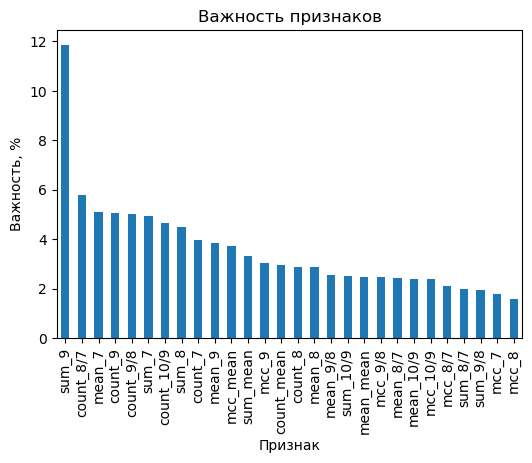

In [74]:
#Построим гарфик важности признаков
importance.plot(kind='bar', 
                title='Важность признаков', 
                x='Признак', 
                y='Важность, %', 
                ylabel='Важность, %', 
                legend=False, figsize=(6,4), fontsize=10);

Найдём корреляцию признаков между собой

In [75]:
corr_table = X_train[list(importance['Признак'])].corr().round(2)

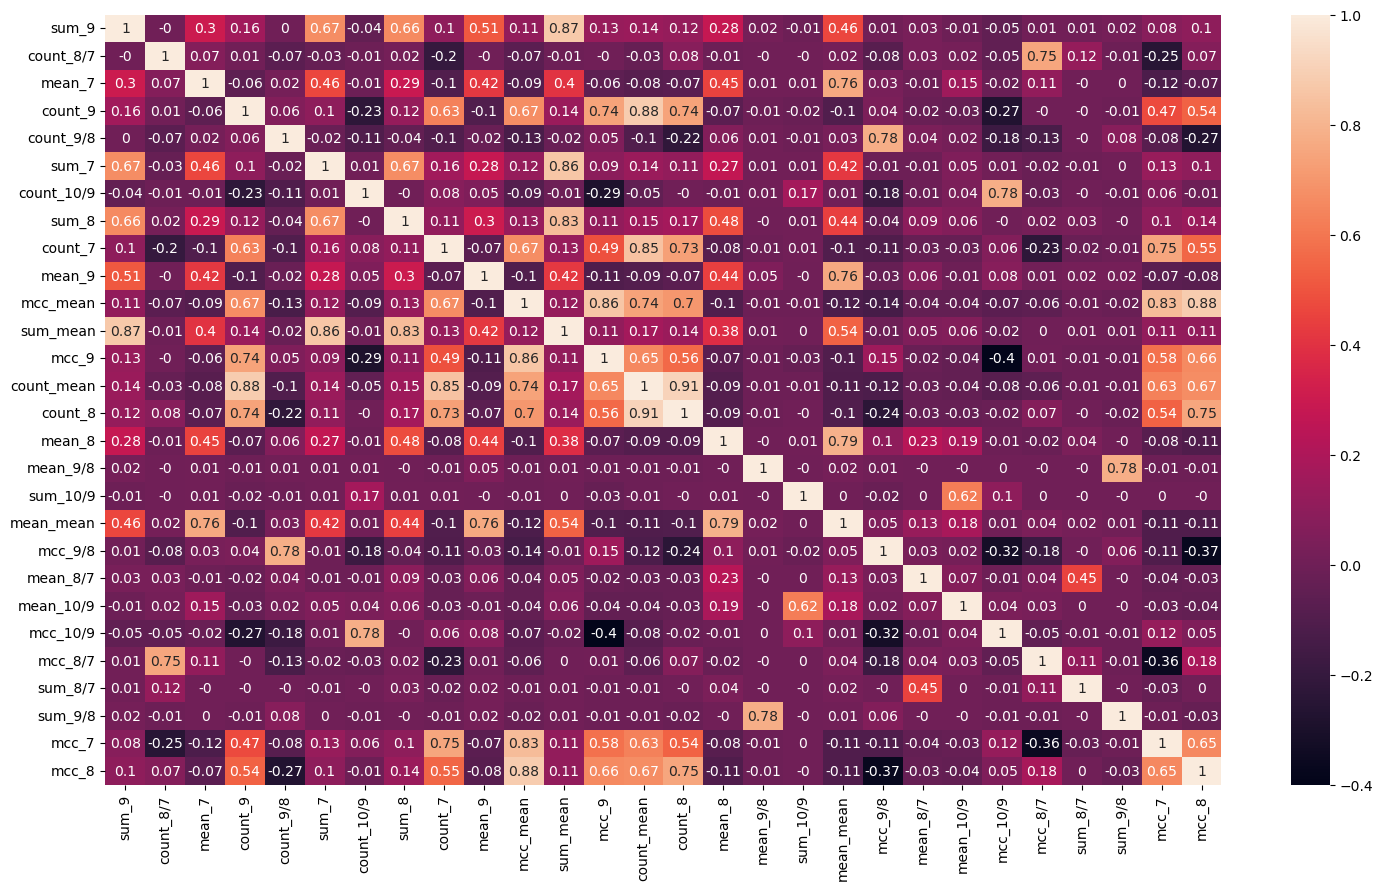

In [76]:
plt.figure(figsize = (18,10))
sns.heatmap(corr_table, annot = True);

Заметна корреляция больше 0.8 между признаками:
- sum_9 & sum_mean
- count_9 & count_mean
- sum_7 & sum_mean
- sum_8 & sum_mean
- count_7 & count_mean
- mcc_mean & mcc_9 / 8 / 7

In [77]:
# Удалим из таблицы признаки с корр. больше 0.8
data_pivot.drop(['sum_mean', 'count_mean', 'mcc_9', 'mcc_8', 'mcc_7'], inplace=True, axis=1)

In [78]:
# Удалим из таблицы признаки с важностью меньше 3%
data_pivot.drop(['count_8','mean_8','mean_9/8','sum_10/9','mean_mean','mcc_9/8','mean_8/7','mean_10/9','mcc_10/9','mcc_8/7','sum_8/7','sum_9/8'], inplace=True, axis=1)

In [79]:
X_train, y_train, X_test = train_test(data_pivot)

In [80]:
X_train_s, X_test_s = standartization(X_train, X_test)

In [81]:
%%time
model = CatBoostRegressor(verbose=0, random_state=12345)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print("Лучшее значение WMAE:", grid_search.best_score_ * -1)

Лучшие гиперпараметры: {'depth': 8, 'iterations': 600, 'learning_rate': 0.05}
Лучшее значение WMAE: 1.5606312329673786
CPU times: total: 29.9 s
Wall time: 22min 27s


Лучшие гиперпараметры: {'depth': 8, 'iterations': 600, 'learning_rate': 0.05}

Лучшее значение WMAE: 1.5606312329673786

In [82]:
# Объявим модель
model = CatBoostRegressor(iterations=600, learning_rate=0.05, depth=8, verbose=False, random_seed=42)

In [83]:
# Обучим модель на тренировочной выборке
model.fit(X_train_s, y_train)

In [84]:
#Создадим таблицу с важностью признаков
importance = pd.DataFrame(model.feature_importances_, X_train.columns)
importance.reset_index(inplace=True)
importance.columns = ['Признак', 'Важность, %']
importance.sort_values('Важность, %', ascending=False, inplace=True)
importance.reset_index(drop=True, inplace=True)
importance

,Признак,"Важность, %"
0,sum_9,15.770720
1,sum_8,10.260529
2,mcc_mean,9.250598
3,sum_7,9.018473
4,count_8/7,8.857201
5,mean_7,8.421189
6,mean_9,8.220908
7,count_10/9,7.952145
8,count_9/8,7.753117
9,count_7,7.451289


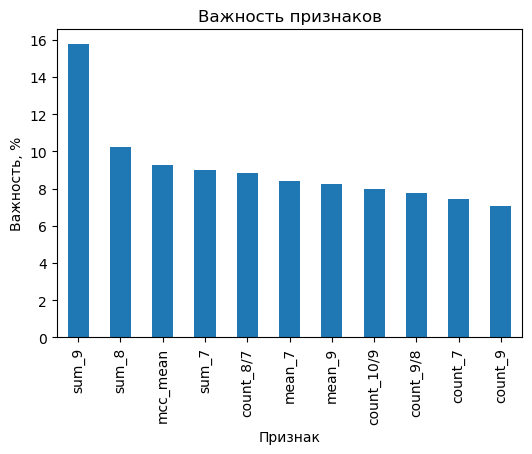

In [85]:
#Построим гарфик важности признаков
importance.plot(kind='bar', 
                title='Важность признаков', 
                x='Признак', 
                y='Важность, %', 
                ylabel='Важность, %', 
                legend=False, figsize=(6,4), fontsize=10);

In [86]:
corr_table = X_train[list(importance['Признак'])].corr().round(2)

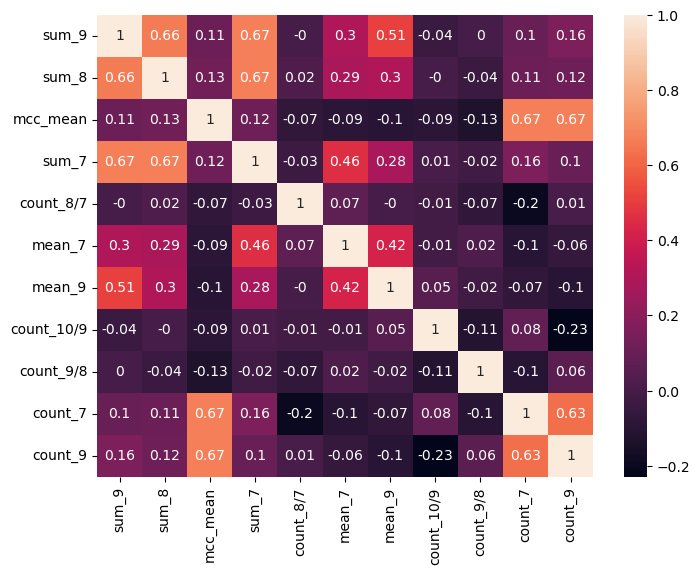

In [87]:
plt.figure(figsize = (8,6))
sns.heatmap(corr_table, annot = True);

## Подготовим предсказание для Кэгл ##

In [88]:
# Объявим модель
model = CatBoostRegressor(iterations=600, learning_rate=0.05, depth=8, verbose=False, random_seed=42)

In [89]:
# Обучим модель на тренировочной выборке
model.fit(X_train_s, y_train)

In [90]:
# Получим предсказания на тестовой в.
predict = model.predict(X_test_s)

In [91]:
predict = pd.Series(predict)

In [92]:
predict = predict.apply(lambda x: int(x))

In [93]:
client_nums = data_pivot.loc[data_pivot['target'].isna(), 'client_num'].reset_index(drop=True)

In [94]:
predict_data = pd.concat([client_nums, predict], axis=1)

In [95]:
predict_data.columns = ['client_num', 'target']

In [96]:
predict_data['target'].value_counts()

target
1    16232
2    13313
3     6541
0     1880
4     1104
5       73
Name: count, dtype: int64

In [97]:
predict_data.to_csv('predict.csv', index=False)

## Объединим выборки и заново обучим модель ##

In [98]:
data_pivot_union = data_pivot.copy()

In [99]:
predict_data

,client_num,target
0,0,2
1,10,4
2,11,2
3,14,4
4,16,1
...,...,...
39138,109127,1
39139,109128,1
39140,109130,1
39141,109137,1


In [100]:
data_pivot_union = data_pivot_union.merge(predict_data, how='left', on='client_num')

In [101]:
data_pivot_union

,client_num,count_7,count_9,mean_7,mean_9,sum_7,sum_8,sum_9,mcc_mean,target_x,count_8/7,count_9/8,count_10/9,target_y
0,0,10.0,56.0,726.100000,762.714286,7261.0,56962.0,42712.0,11.000000,NaN,6.600000,0.848485,0.785714,2.0
1,1,95.0,77.0,4449.989474,2655.272727,422749.0,236673.0,204456.0,19.333333,4.0,0.715789,1.132353,1.038961,NaN
2,2,128.0,95.0,895.679688,1567.484211,114647.0,80550.0,148911.0,19.666667,5.0,0.601562,1.233766,1.052632,NaN
3,3,42.0,47.0,35331.261905,1485.297872,1483913.0,68103.0,69809.0,12.333333,3.0,1.380952,0.810345,1.042553,NaN
4,4,60.0,40.0,1523.700000,1116.600000,91422.0,63710.0,44664.0,6.333333,5.0,0.366667,1.818182,1.016667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108473,109138,34.0,8.0,833.144345,13058.250000,31582.0,131817.0,104466.0,2.500000,2.0,0.235294,1.000000,1.000000,NaN
108474,109139,5.0,32.0,599.200000,791.822876,2996.0,6644.0,28207.0,4.500000,0.0,2.000000,3.200000,0.234375,NaN
108475,109140,2.0,32.0,184.500000,791.822876,369.0,22920.0,28207.0,3.500000,NaN,7.000000,2.285714,0.250000,1.0
108476,109141,2.0,1.0,6025.000000,378.000000,12050.0,49415.0,378.0,4.000000,0.0,6.500000,0.076923,5.333333,NaN


In [102]:
data_pivot_union.columns

Index(['client_num', 'count_7', 'count_9', 'mean_7', 'mean_9', 'sum_7',
       'sum_8', 'sum_9', 'mcc_mean', 'target_x', 'count_8/7', 'count_9/8',
       'count_10/9', 'target_y'],
      dtype='object')

In [103]:
data_pivot_union['target'] = data_pivot_union['target_x'].combine_first(data_pivot_union['target_y'])

In [104]:
data_pivot_union.drop(['target_x', 'target_y'], axis=1, inplace=True)

In [105]:
data_pivot_union.columns

Index(['client_num', 'count_7', 'count_9', 'mean_7', 'mean_9', 'sum_7',
       'sum_8', 'sum_9', 'mcc_mean', 'count_8/7', 'count_9/8', 'count_10/9',
       'target'],
      dtype='object')

In [106]:
y_union = data_pivot_union['target']
y_union = y_union.astype('int')

In [107]:
y_union

0         2
1         4
2         5
3         3
4         5
         ..
108473    2
108474    0
108475    1
108476    0
108477    0
Name: target, Length: 108478, dtype: int32

In [108]:
X_union = data_pivot_union.drop(['client_num', 'target'], axis=1) # Оставим только нужные признаки

In [109]:
X_union.columns

Index(['count_7', 'count_9', 'mean_7', 'mean_9', 'sum_7', 'sum_8', 'sum_9',
       'mcc_mean', 'count_8/7', 'count_9/8', 'count_10/9'],
      dtype='object')

In [110]:
X_union_s, X_test_s = standartization(X_union, X_test)

In [111]:
# Объявим модель
model = CatBoostRegressor(iterations=600, learning_rate=0.05, depth=8, verbose=False, random_seed=42)

In [112]:
# Обучим модель на тренировочной выборке
model.fit(X_union_s, y_union)

In [113]:
# Получим предсказания на тестовой в.
predict = model.predict(X_test_s)

In [114]:
predict = pd.Series(predict)

In [115]:
predict = predict.apply(lambda x: int(x))

In [116]:
client_nums = data_pivot.loc[data_pivot['target'].isna(), 'client_num'].reset_index(drop=True)

In [117]:
predict_data = pd.concat([client_nums, predict], axis=1)

In [118]:
predict_data.columns = ['client_num', 'target']

In [119]:
predict_data['target'].value_counts()

target
1    17329
2    12293
3     5259
0     3486
4      760
5       16
Name: count, dtype: int64

In [120]:
predict_data.to_csv('predict.csv', index=False)